# Analysis of the Sensitivity with respect to the Features and Labels Noise

## Preamble

In [1]:
import torch
import gpytorch
import numpy as np

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from importlib.resources import files

from manifold_gp.kernels.riemann_matern_kernel import RiemannMaternKernel
from manifold_gp.models.riemann_gp import RiemannGP
from manifold_gp.models.vanilla_gp import VanillaGP
from manifold_gp.utils.mesh_helper import groundtruth_from_samples
from manifold_gp.utils.file_read import get_data

from manifold_gp.priors.inverse_gamma_prior import InverseGammaPrior
from gpytorch.priors import NormalPrior, GammaPrior

## Dataset Preprocessing

### Load

In [3]:
data_path = files('manifold_gp.data').joinpath('dumbbell.msh')
data = get_data(data_path, "Nodes", "Elements")

vertices = data['Nodes'][:, 1:-1]
edges = data['Elements'][:, -2:].astype(int) - 1
truth, geodesics = groundtruth_from_samples(vertices,edges)

sampled_x = torch.from_numpy(vertices).float()
sampled_y = torch.from_numpy(truth).float()
(m, n) = sampled_x.shape

num_train = 10
num_test = 10
normalize_features = False
normalize_labels = True

### Noise Features

In [4]:
noise_sampled_x = 0.0
noisy_x = sampled_x + noise_sampled_x * torch.randn(m, n)

### Trainset & Testset

In [5]:
torch.manual_seed(1337)
rand_idx = torch.randperm(m)
train_idx = rand_idx[:num_train]
train_x, train_y = noisy_x[train_idx, :], sampled_y[train_idx]

noise_train_y = 0.01
train_y += noise_train_y * torch.randn(num_train)

test_idx = rand_idx[num_train:num_train+num_test]
test_x, test_y = sampled_x[test_idx, :], sampled_y[test_idx]

noise_test_y = 0.0
test_y += noise_test_y * torch.randn(num_test)

if normalize_features:
    mu_x, std_x = noisy_x.mean(dim=-2, keepdim=True), train_x.std(dim=-2, keepdim=True) + 1e-6
    noisy_x.sub_(mu_x).div_(std_x)
    train_x.sub_(mu_x).div_(std_x)
    test_x.sub_(mu_x).div_(std_x)
    
if normalize_labels:
    mu_y, std_y = train_y.mean(), train_y.std()
    train_y.sub_(mu_y).div_(std_y)
    test_y.sub_(mu_y).div_(std_y)
    sampled_y.sub_(mu_y).div_(std_y)

### Hyperparameters Priors

In [5]:
import scipy.spatial as ss
neighbors = 10
kd_tree = ss.KDTree(vertices)
v = np.sort(kd_tree.query(vertices, k=neighbors+1)[0][:, 1:].ravel())
percentile_99 = int(np.round(v.shape[0]*0.99))
gamma_rate = 100.0/np.std(v)
gamma_concentration = gamma_rate * v[percentile_99] + 1
igamma_concentration = 100.0/np.std(v)
igamma_rate = (igamma_concentration+1)*v[percentile_99]

### Move Data to Device

In [6]:
noisy_x, sampled_y = noisy_x.contiguous(), sampled_y.contiguous()
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
noisy_x = noisy_x.to(device)
train_x, train_y = train_x.to(device), train_y.to(device)
test_x, test_y = test_x.to(device), test_y.to(device)

gamma_concentration, gamma_rate = torch.tensor([gamma_concentration]).to(device), torch.tensor([gamma_rate]).to(device)
igamma_concentration, igamma_rate = torch.tensor([igamma_concentration]).to(device), torch.tensor([igamma_rate]).to(device)

if normalize_features:
    mu_x, std_x = mu_x.to(device), std_x.to(device)

## Vanilla Pre-Trained

In [7]:
%%capture
model_vanilla = VanillaGP(
    train_x, 
    train_y, 
    gpytorch.likelihoods.GaussianLikelihood(), 
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # gpytorch.kernels.RBFKernel(), gpytorch.kernels.RFFKernel(100)
).to(device)
model_vanilla.vanilla_train(lr=1e-1, iter=200, verbose=True)
model_vanilla.likelihood.eval()
model_vanilla.eval()

## Model

In [8]:
%%capture
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-8),
    noise_prior=None  # NormalPrior(torch.tensor([0.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

kernel = gpytorch.kernels.ScaleKernel(
    RiemannMaternKernel(
        nu=2,
        nodes=noisy_x,
        neighbors=10,
        operator="randomwalk",
        modes=50,
        ball_scale=3.0,
        support_kernel=gpytorch.kernels.RBFKernel(),
        epsilon_prior=GammaPrior(gamma_concentration, gamma_rate),
        lengthscale_prior=None, # InverseGammaPrior(igamma_concentration, igamma_rate)
    ),
    outputscale_prior=None  # NormalPrior(torch.tensor([1.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

model = RiemannGP(train_x, train_y, likelihood, kernel, train_idx).to(device)

## Train

In [9]:
%%capture
hypers = {
    'likelihood.noise_covar.noise': 1e-1, # 0.037,
    'covar_module.base_kernel.epsilon': 0.5, # 0.029,
    'covar_module.base_kernel.lengthscale': 0.5, # 5.130,
    'covar_module.outputscale': 1.0, # 0.0656,
    'covar_module.base_kernel.support_kernel.lengthscale': 1.0,
}
model.initialize(**hypers)

In [10]:
model.manifold_informed_train(lr=1e-2, iter=500, norm_step_size=100, verbose=True)

Iter: 0, LR: 0.010, Loss: 5677.292, NoiseVar: 0.100, SignalVar: 15.397, Lengthscale: 0.500, Epsilon: 0.500
Iter: 1, LR: 0.010, Loss: 5624.419, NoiseVar: 0.099, SignalVar: 15.387, Lengthscale: 0.504, Epsilon: 0.496
Iter: 2, LR: 0.010, Loss: 5571.898, NoiseVar: 0.098, SignalVar: 15.377, Lengthscale: 0.508, Epsilon: 0.492
Iter: 3, LR: 0.010, Loss: 5519.735, NoiseVar: 0.097, SignalVar: 15.367, Lengthscale: 0.512, Epsilon: 0.488
Iter: 4, LR: 0.010, Loss: 5467.934, NoiseVar: 0.096, SignalVar: 15.357, Lengthscale: 0.516, Epsilon: 0.484
Iter: 5, LR: 0.010, Loss: 5416.500, NoiseVar: 0.095, SignalVar: 15.348, Lengthscale: 0.520, Epsilon: 0.481
Iter: 6, LR: 0.010, Loss: 5365.439, NoiseVar: 0.094, SignalVar: 15.338, Lengthscale: 0.524, Epsilon: 0.477
Iter: 7, LR: 0.010, Loss: 5314.754, NoiseVar: 0.094, SignalVar: 15.328, Lengthscale: 0.528, Epsilon: 0.473
Iter: 8, LR: 0.010, Loss: 5264.450, NoiseVar: 0.093, SignalVar: 15.319, Lengthscale: 0.532, Epsilon: 0.469
Iter: 9, LR: 0.010, Loss: 5214.531, N

Iter: 78, LR: 0.010, Loss: 2703.665, NoiseVar: 0.135, SignalVar: 15.681, Lengthscale: 0.401, Epsilon: 0.276
Iter: 79, LR: 0.010, Loss: 2678.963, NoiseVar: 0.136, SignalVar: 15.688, Lengthscale: 0.399, Epsilon: 0.274
Iter: 80, LR: 0.010, Loss: 2654.524, NoiseVar: 0.137, SignalVar: 15.695, Lengthscale: 0.396, Epsilon: 0.272
Iter: 81, LR: 0.010, Loss: 2630.344, NoiseVar: 0.138, SignalVar: 15.702, Lengthscale: 0.394, Epsilon: 0.270
Iter: 82, LR: 0.010, Loss: 2606.418, NoiseVar: 0.139, SignalVar: 15.709, Lengthscale: 0.392, Epsilon: 0.268
Iter: 83, LR: 0.010, Loss: 2582.746, NoiseVar: 0.140, SignalVar: 15.716, Lengthscale: 0.390, Epsilon: 0.266
Iter: 84, LR: 0.010, Loss: 2559.324, NoiseVar: 0.141, SignalVar: 15.723, Lengthscale: 0.388, Epsilon: 0.264
Iter: 85, LR: 0.010, Loss: 2536.150, NoiseVar: 0.142, SignalVar: 15.730, Lengthscale: 0.385, Epsilon: 0.263
Iter: 86, LR: 0.010, Loss: 2513.220, NoiseVar: 0.143, SignalVar: 15.736, Lengthscale: 0.383, Epsilon: 0.261
Iter: 87, LR: 0.010, Loss: 2

Iter: 154, LR: 0.010, Loss: 1399.113, NoiseVar: 0.249, SignalVar: 16.146, Lengthscale: 0.275, Epsilon: 0.172
Iter: 155, LR: 0.010, Loss: 1387.735, NoiseVar: 0.251, SignalVar: 16.152, Lengthscale: 0.273, Epsilon: 0.171
Iter: 156, LR: 0.010, Loss: 1376.465, NoiseVar: 0.253, SignalVar: 16.158, Lengthscale: 0.272, Epsilon: 0.170
Iter: 157, LR: 0.010, Loss: 1365.303, NoiseVar: 0.256, SignalVar: 16.163, Lengthscale: 0.271, Epsilon: 0.169
Iter: 158, LR: 0.010, Loss: 1354.248, NoiseVar: 0.258, SignalVar: 16.169, Lengthscale: 0.270, Epsilon: 0.168
Iter: 159, LR: 0.010, Loss: 1343.299, NoiseVar: 0.260, SignalVar: 16.174, Lengthscale: 0.269, Epsilon: 0.167
Iter: 160, LR: 0.010, Loss: 1332.454, NoiseVar: 0.263, SignalVar: 16.180, Lengthscale: 0.268, Epsilon: 0.166
Iter: 161, LR: 0.010, Loss: 1321.712, NoiseVar: 0.265, SignalVar: 16.185, Lengthscale: 0.266, Epsilon: 0.165
Iter: 162, LR: 0.010, Loss: 1311.072, NoiseVar: 0.267, SignalVar: 16.191, Lengthscale: 0.265, Epsilon: 0.164
Iter: 163, LR: 0.01

Iter: 230, LR: 0.010, Loss: 775.948, NoiseVar: 0.448, SignalVar: 16.644, Lengthscale: 0.192, Epsilon: 0.119
Iter: 231, LR: 0.010, Loss: 770.241, NoiseVar: 0.450, SignalVar: 16.651, Lengthscale: 0.191, Epsilon: 0.118
Iter: 232, LR: 0.010, Loss: 764.583, NoiseVar: 0.452, SignalVar: 16.659, Lengthscale: 0.190, Epsilon: 0.118
Iter: 233, LR: 0.010, Loss: 758.973, NoiseVar: 0.453, SignalVar: 16.666, Lengthscale: 0.189, Epsilon: 0.117
Iter: 234, LR: 0.010, Loss: 753.410, NoiseVar: 0.455, SignalVar: 16.674, Lengthscale: 0.188, Epsilon: 0.117
Iter: 235, LR: 0.010, Loss: 747.894, NoiseVar: 0.457, SignalVar: 16.681, Lengthscale: 0.187, Epsilon: 0.116
Iter: 236, LR: 0.010, Loss: 742.425, NoiseVar: 0.458, SignalVar: 16.688, Lengthscale: 0.186, Epsilon: 0.116
Iter: 237, LR: 0.010, Loss: 737.002, NoiseVar: 0.460, SignalVar: 16.696, Lengthscale: 0.185, Epsilon: 0.115
Iter: 238, LR: 0.010, Loss: 731.625, NoiseVar: 0.462, SignalVar: 16.703, Lengthscale: 0.185, Epsilon: 0.115
Iter: 239, LR: 0.010, Loss: 

Iter: 306, LR: 0.010, Loss: 452.390, NoiseVar: 0.522, SignalVar: 17.195, Lengthscale: 0.142, Epsilon: 0.088
Iter: 307, LR: 0.010, Loss: 449.304, NoiseVar: 0.522, SignalVar: 17.202, Lengthscale: 0.141, Epsilon: 0.088
Iter: 308, LR: 0.010, Loss: 446.240, NoiseVar: 0.523, SignalVar: 17.209, Lengthscale: 0.141, Epsilon: 0.088
Iter: 309, LR: 0.010, Loss: 443.201, NoiseVar: 0.523, SignalVar: 17.216, Lengthscale: 0.140, Epsilon: 0.088
Iter: 310, LR: 0.010, Loss: 440.184, NoiseVar: 0.524, SignalVar: 17.223, Lengthscale: 0.140, Epsilon: 0.087
Iter: 311, LR: 0.010, Loss: 437.190, NoiseVar: 0.524, SignalVar: 17.230, Lengthscale: 0.140, Epsilon: 0.087
Iter: 312, LR: 0.010, Loss: 434.220, NoiseVar: 0.525, SignalVar: 17.237, Lengthscale: 0.139, Epsilon: 0.087
Iter: 313, LR: 0.010, Loss: 431.271, NoiseVar: 0.525, SignalVar: 17.245, Lengthscale: 0.139, Epsilon: 0.086
Iter: 314, LR: 0.010, Loss: 428.345, NoiseVar: 0.525, SignalVar: 17.252, Lengthscale: 0.138, Epsilon: 0.086
Iter: 315, LR: 0.010, Loss: 

Iter: 382, LR: 0.010, Loss: 272.645, NoiseVar: 0.551, SignalVar: 17.734, Lengthscale: 0.114, Epsilon: 0.070
Iter: 383, LR: 0.010, Loss: 270.878, NoiseVar: 0.552, SignalVar: 17.741, Lengthscale: 0.113, Epsilon: 0.070
Iter: 384, LR: 0.010, Loss: 269.124, NoiseVar: 0.552, SignalVar: 17.748, Lengthscale: 0.113, Epsilon: 0.070
Iter: 385, LR: 0.010, Loss: 267.382, NoiseVar: 0.552, SignalVar: 17.755, Lengthscale: 0.113, Epsilon: 0.069
Iter: 386, LR: 0.010, Loss: 265.652, NoiseVar: 0.553, SignalVar: 17.762, Lengthscale: 0.112, Epsilon: 0.069
Iter: 387, LR: 0.010, Loss: 263.934, NoiseVar: 0.553, SignalVar: 17.770, Lengthscale: 0.112, Epsilon: 0.069
Iter: 388, LR: 0.010, Loss: 262.228, NoiseVar: 0.553, SignalVar: 17.777, Lengthscale: 0.112, Epsilon: 0.069
Iter: 389, LR: 0.010, Loss: 260.534, NoiseVar: 0.554, SignalVar: 17.784, Lengthscale: 0.112, Epsilon: 0.069
Iter: 390, LR: 0.010, Loss: 258.852, NoiseVar: 0.554, SignalVar: 17.791, Lengthscale: 0.111, Epsilon: 0.068
Iter: 391, LR: 0.010, Loss: 

Iter: 458, LR: 0.010, Loss: 167.754, NoiseVar: 0.572, SignalVar: 18.277, Lengthscale: 0.095, Epsilon: 0.058
Iter: 459, LR: 0.010, Loss: 166.701, NoiseVar: 0.572, SignalVar: 18.284, Lengthscale: 0.095, Epsilon: 0.058
Iter: 460, LR: 0.010, Loss: 165.655, NoiseVar: 0.572, SignalVar: 18.291, Lengthscale: 0.095, Epsilon: 0.058
Iter: 461, LR: 0.010, Loss: 164.616, NoiseVar: 0.572, SignalVar: 18.298, Lengthscale: 0.095, Epsilon: 0.057
Iter: 462, LR: 0.010, Loss: 163.584, NoiseVar: 0.572, SignalVar: 18.305, Lengthscale: 0.095, Epsilon: 0.057
Iter: 463, LR: 0.010, Loss: 162.558, NoiseVar: 0.573, SignalVar: 18.313, Lengthscale: 0.094, Epsilon: 0.057
Iter: 464, LR: 0.010, Loss: 161.539, NoiseVar: 0.573, SignalVar: 18.320, Lengthscale: 0.094, Epsilon: 0.057
Iter: 465, LR: 0.010, Loss: 160.527, NoiseVar: 0.573, SignalVar: 18.327, Lengthscale: 0.094, Epsilon: 0.057
Iter: 466, LR: 0.010, Loss: 159.522, NoiseVar: 0.573, SignalVar: 18.334, Lengthscale: 0.094, Epsilon: 0.057
Iter: 467, LR: 0.010, Loss: 

## Evaluation

In [11]:
%%capture
likelihood.eval()
model.eval()


## Metrics

In [12]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_test = likelihood(model(test_x))

    mean_test = preds_test.mean
        
    error = test_y - preds_test.mean
    covar = preds_test.lazy_covariance_matrix.evaluate_kernel()
    inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)
    
    rmse = (error.square().sum()/num_test).sqrt()
    nll = 0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/num_test
    
print("RMSE: ", rmse)
print("NLL: ", nll)

RMSE:  tensor(1.1315, device='cuda:0')
NLL:  tensor(1.4557, device='cuda:0')


## Plot

In [13]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_manifold = model(noisy_x)
    
    resolution = 100
    x, y = torch.meshgrid(torch.linspace(-1.6, 1.6, resolution), torch.linspace(-1.0, 1.0, resolution), indexing='xy')
    grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
    
    if normalize_features:
        preds_ambient = model(grid_x.sub(mu_x).div(std_x))
        preds_vanilla = model_vanilla(grid_x.sub(mu_x).div(std_x))
        scale_ambient = kernel.base_kernel.scale_posterior(grid_x.sub(mu_x).div(std_x), beta=0.01)
        sampled_x.mul_(std_x).add_(mu_x)
        train_x.mul_(std_x).add_(mu_x)
        test_x.mul_(std_x).add_(mu_x)
    else:
        preds_ambient = model(grid_x)
        preds_vanilla = model_vanilla(grid_x)
        scale_ambient = kernel.base_kernel.scale_posterior(grid_x, beta=0.01)

### Ground Truth

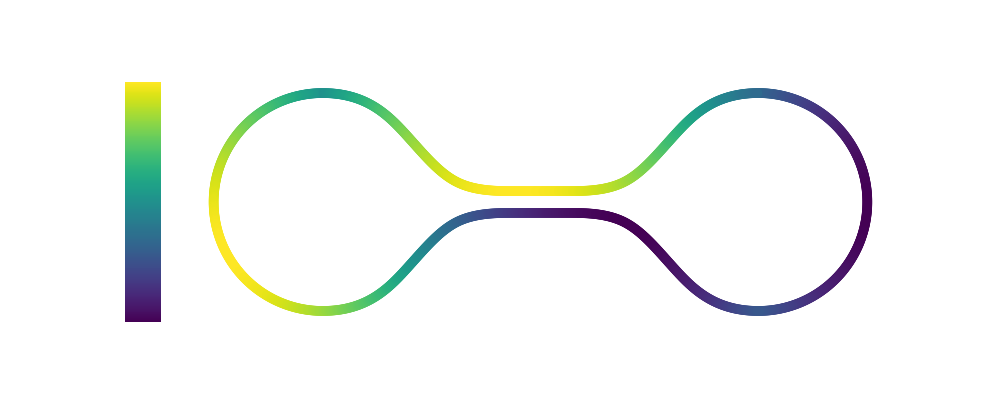

In [14]:
with torch.no_grad():
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    im = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=sampled_y.numpy(), vmin=sampled_y.min(), vmax=sampled_y.max())
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="5%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax)
    cax.yaxis.set_ticks_position("left")
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    cbar.ax.tick_params(size=0)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    fig.patch.set_visible(False)
    ax.axis('off')
    
    ax.axis('equal')

### Posterior Mean

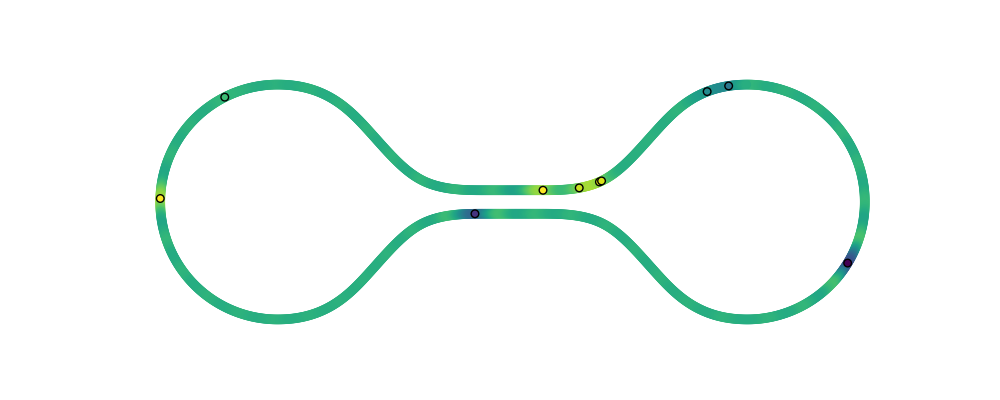

In [15]:
posterior_mean_manifold = preds_manifold.mean.cpu().numpy()
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
im = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=posterior_mean_manifold, vmin=sampled_y.min(), vmax=sampled_y.max())
# ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=1.0)
ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c=posterior_mean_manifold[train_idx],s=30.0, zorder=2, edgecolors='black')
divider = make_axes_locatable(ax)
# cax = divider.append_axes("left", size="5%", pad=0.2)
# cbar = fig.colorbar(im, cax=cax)
# cax.yaxis.set_ticks_position("left")
# cbar.outline.set_visible(False)
# cbar.set_ticks([])
# cbar.ax.tick_params(size=0)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.patch.set_visible(False)
ax.axis('off')

ax.axis('equal')

fig.savefig("1d_high_noise.png", format="png", bbox_inches="tight")


### Kernel Evaluation

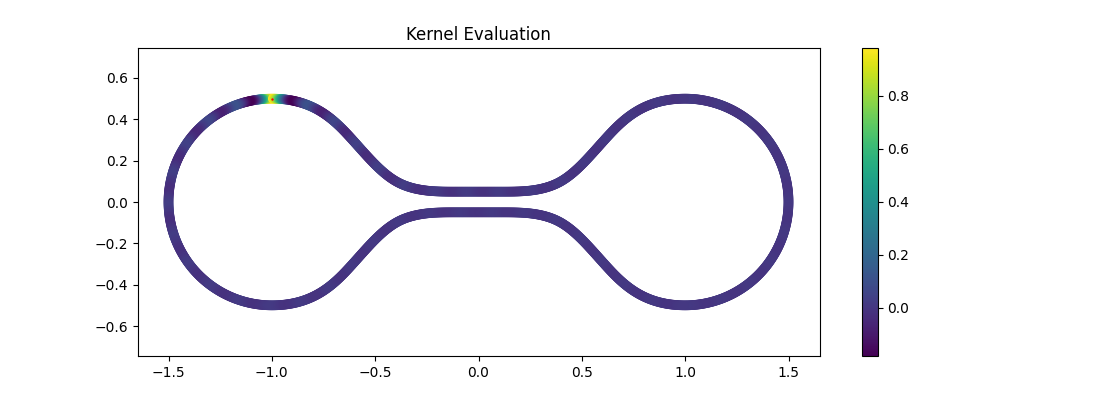

In [16]:
with torch.no_grad():
    k_base = kernel.base_kernel(noisy_x[0, :].unsqueeze(0), noisy_x[0, :].unsqueeze(0)).evaluate()
    kernel_eval_manifold = (kernel.base_kernel(noisy_x[0, :].unsqueeze(0), noisy_x).evaluate()/k_base).squeeze().cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=kernel_eval_manifold)
    ax.scatter(noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Kernel Evaluation')

### Features

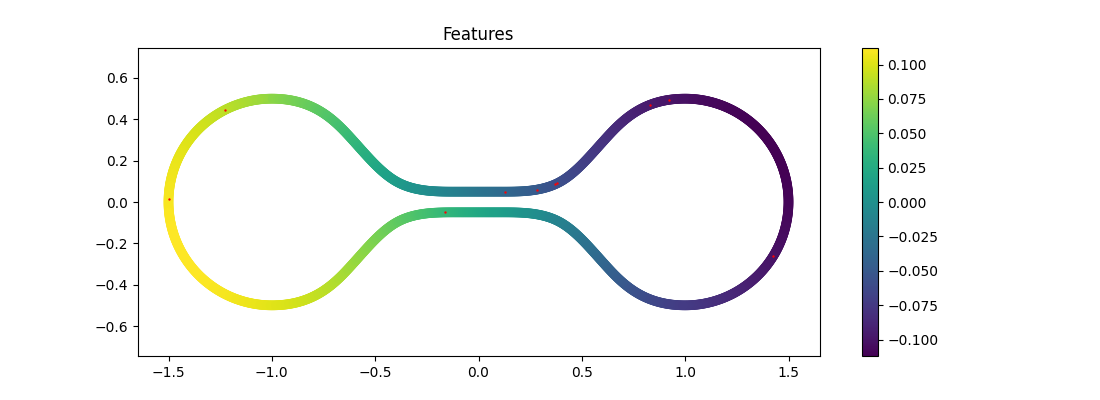

In [17]:
with torch.no_grad():
    c = 3.0
    l_features = kernel.base_kernel.features(noisy_x, c=c)[:,2].cpu().numpy()
    e_features = kernel.base_kernel.eigenvectors[:,2].cpu().numpy()
    f_features = kernel.base_kernel.base_feature._featurize(noisy_x)[:,2].cpu().numpy()
    tmp = kernel.base_kernel.laplace_features(noisy_x)[:,1].cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=e_features)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    circle = plt.Circle((noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1]), 
                        c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
#     ax.add_patch(circle)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Features')

### Prior Standard Deviation

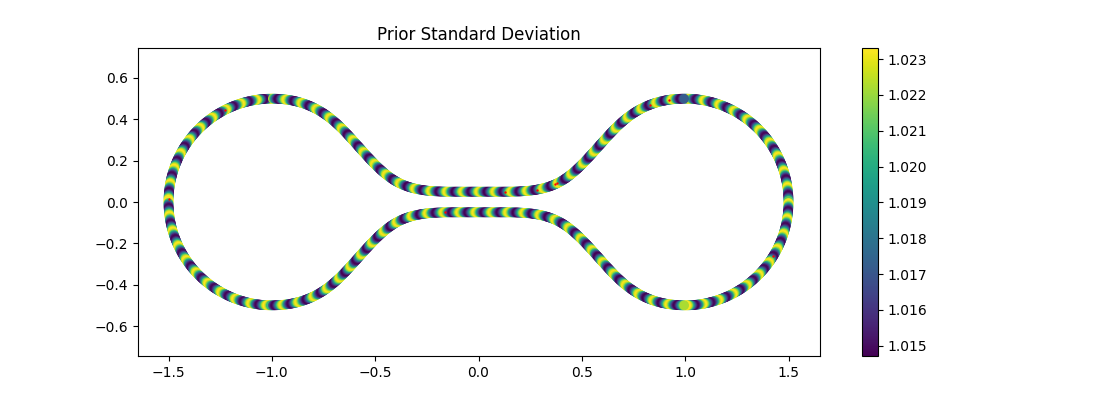

In [18]:
with torch.no_grad():
    prior_std_manifold = model.covar_module(noisy_x, noisy_x, diag=True).sqrt().cpu().numpy()
#     prior_std_manifold = kernel.base_kernel(noisy_x, noisy_x, diag=True).sqrt().cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=prior_std_manifold)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Prior Standard Deviation')

### Posterior Standard Deviation

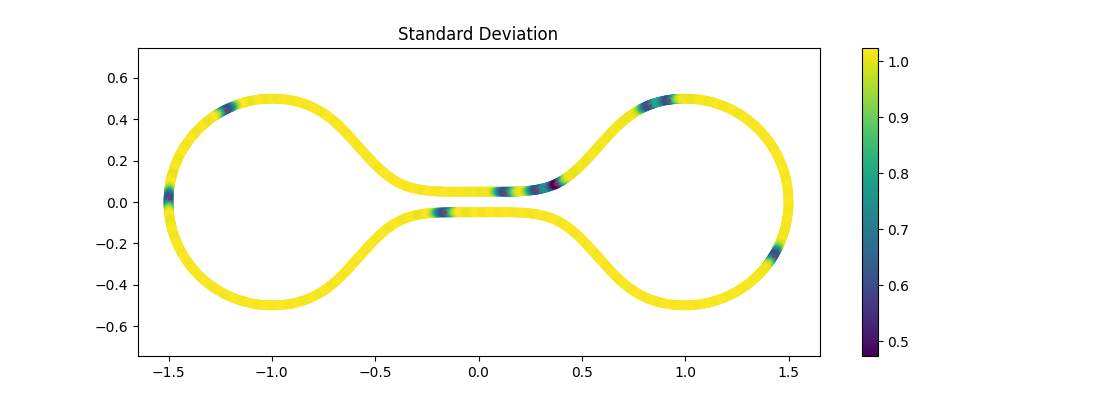

In [19]:
with torch.no_grad():
    posterior_std_manifold = preds_manifold.stddev.cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=posterior_std_manifold)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Standard Deviation')

### Ambient Posterior Mean

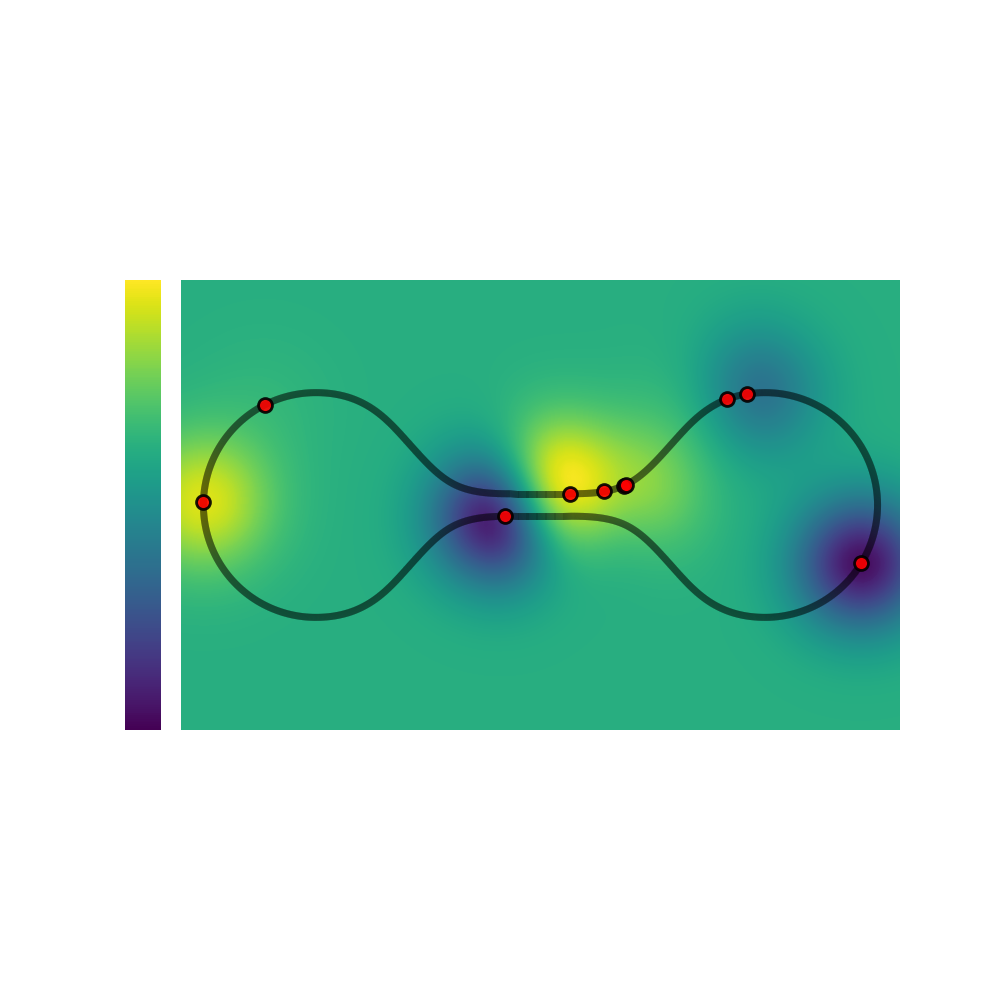

In [20]:
with torch.no_grad():
#     posterior_mean_ambient = preds_ambient.mean.cpu().numpy()
    posterior_mean_ambient = preds_vanilla.mean.cpu().numpy()
#     posterior_mean_ambient = (scale_ambient*preds_ambient.mean + (1-scale_ambient)*preds_vanilla.mean).cpu().numpy()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    levels = np.linspace(-1.85, 1.1, 500)
    im = ax.contourf(x.cpu().numpy(), y.cpu().numpy(), posterior_mean_ambient.reshape(resolution, -1),levels=levels)
    # ax.contour(x.cpu(), y.cpu(), posterior_mean_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
#     ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], facecolors='red',s=100.0, zorder=2, 
               edgecolors='black', linewidth=2, alpha=0.9)
    for edge in edges:
        start = vertices[edge[0]]
        end = vertices[edge[1]]
        ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="5%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax, ticks=[-1.85, 0, 1.1])
    cax.yaxis.set_ticks_position("left")
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    fig.patch.set_visible(False)
    ax.axis('off')
    
    ax.axis('equal')
    
    for c in im.collections:
        c.set_edgecolor("face")
#     fig.tight_layout()
    fig.savefig("1d_vanilla_prediction.png", format="png", bbox_inches="tight")
#     ax.set_title('Posterior Mean')

### Ambient Kernel Evaluation

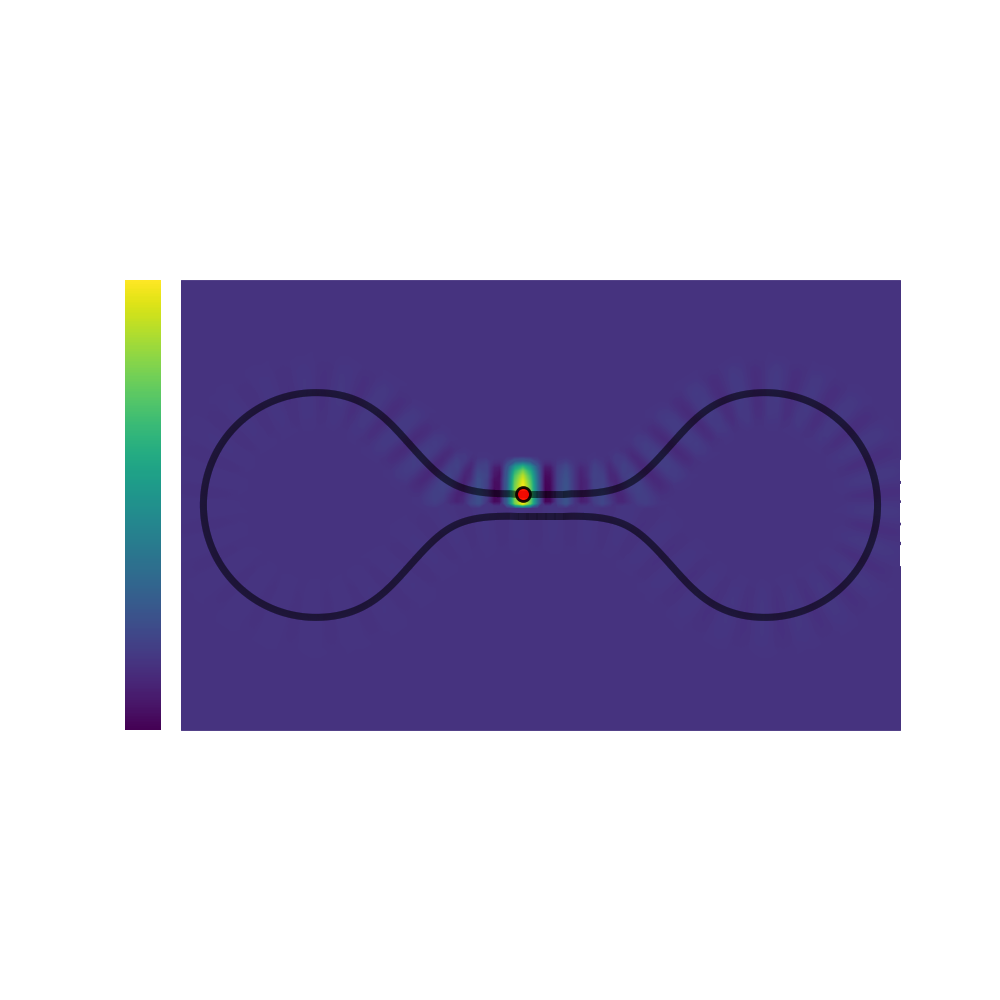

In [21]:
with torch.no_grad():
    kernel_eval_ambient = (scale_ambient*kernel.base_kernel(noisy_x[848, :].unsqueeze(0), grid_x).evaluate().squeeze()).cpu().numpy()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    im = ax.contourf(x.cpu(), y.cpu(), kernel_eval_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), kernel_eval_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    
    ax.scatter(noisy_x.cpu().numpy()[848, 0], noisy_x.cpu().numpy()[848, 1], facecolors='red',s=100.0, zorder=2, 
               edgecolors='black', linewidth=2, alpha=0.9)
    
    for edge in edges:
        start = vertices[edge[0]]
        end = vertices[edge[1]]
        ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="5%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax, ticks=[-1.85, 0, 1.1])
    cax.yaxis.set_ticks_position("left")
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    fig.patch.set_visible(False)
    ax.axis('off')
    
    for c in im.collections:
        c.set_edgecolor("face")
    
    ax.axis('equal')
    fig.savefig("1d_kernel_eval.png", format="png", bbox_inches="tight")

### Ambient Features

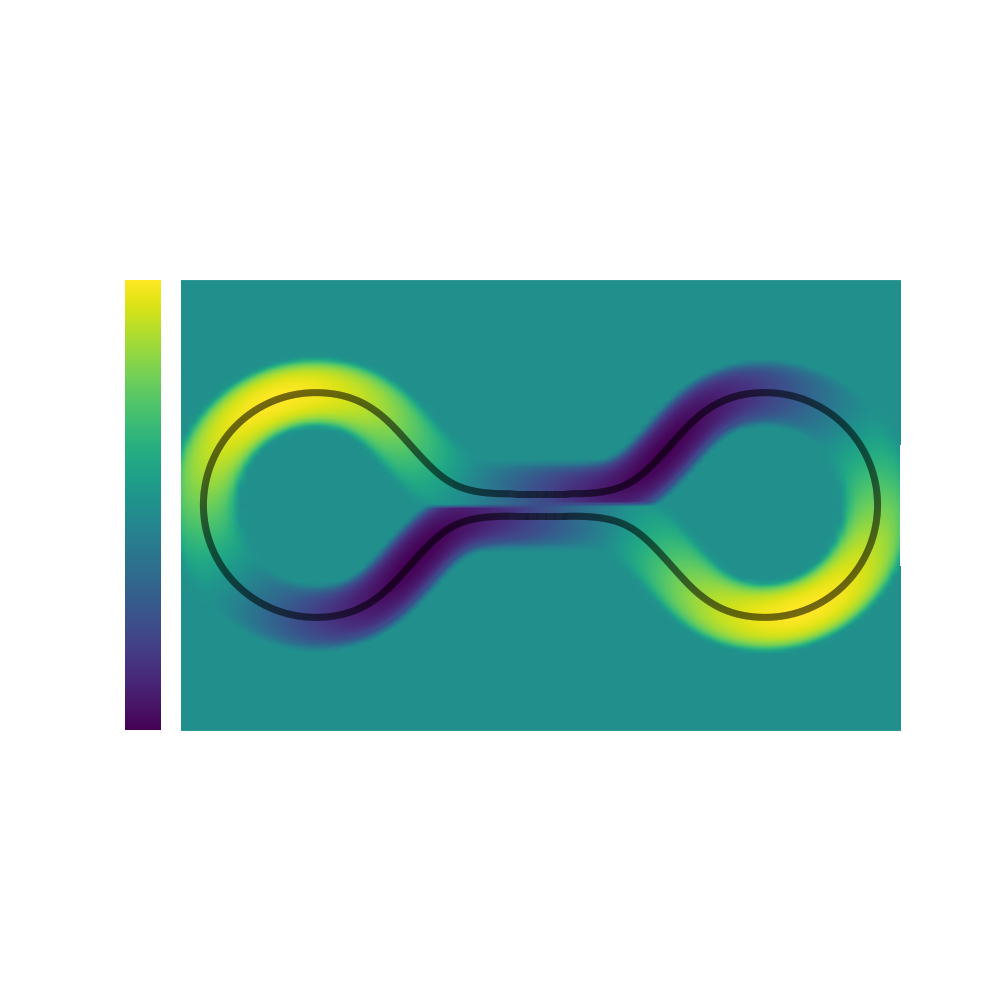

In [22]:
with torch.no_grad():
    c = kernel.base_kernel.ball_scale
    laplace_features_ambient = (scale_ambient*kernel.base_kernel.features(grid_x,  normalize=True, c=c)[:,3]).cpu().numpy()
    fourier_features_ambient = kernel.base_kernel.base_feature._featurize(grid_x,normalize=True)[:,5].cpu().numpy()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    im = ax.contourf(x.cpu(), y.cpu(), laplace_features_ambient.reshape(resolution, -1), 500)
#     ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
#     ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
#     circle = plt.Circle((noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1]), 
#                         c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
#     ax.add_patch(circle)
    for edge in edges:
        start = vertices[edge[0]]
        end = vertices[edge[1]]
        ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="5%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax, ticks=[-1.85, 0, 1.1])
    cax.yaxis.set_ticks_position("left")
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    fig.patch.set_visible(False)
    ax.axis('off')
    
    for c in im.collections:
        c.set_edgecolor("face")
    
    ax.axis('equal')
    fig.savefig("1d_feature_3.png", format="png", bbox_inches="tight")

### Ambient Prior Standard Deviation

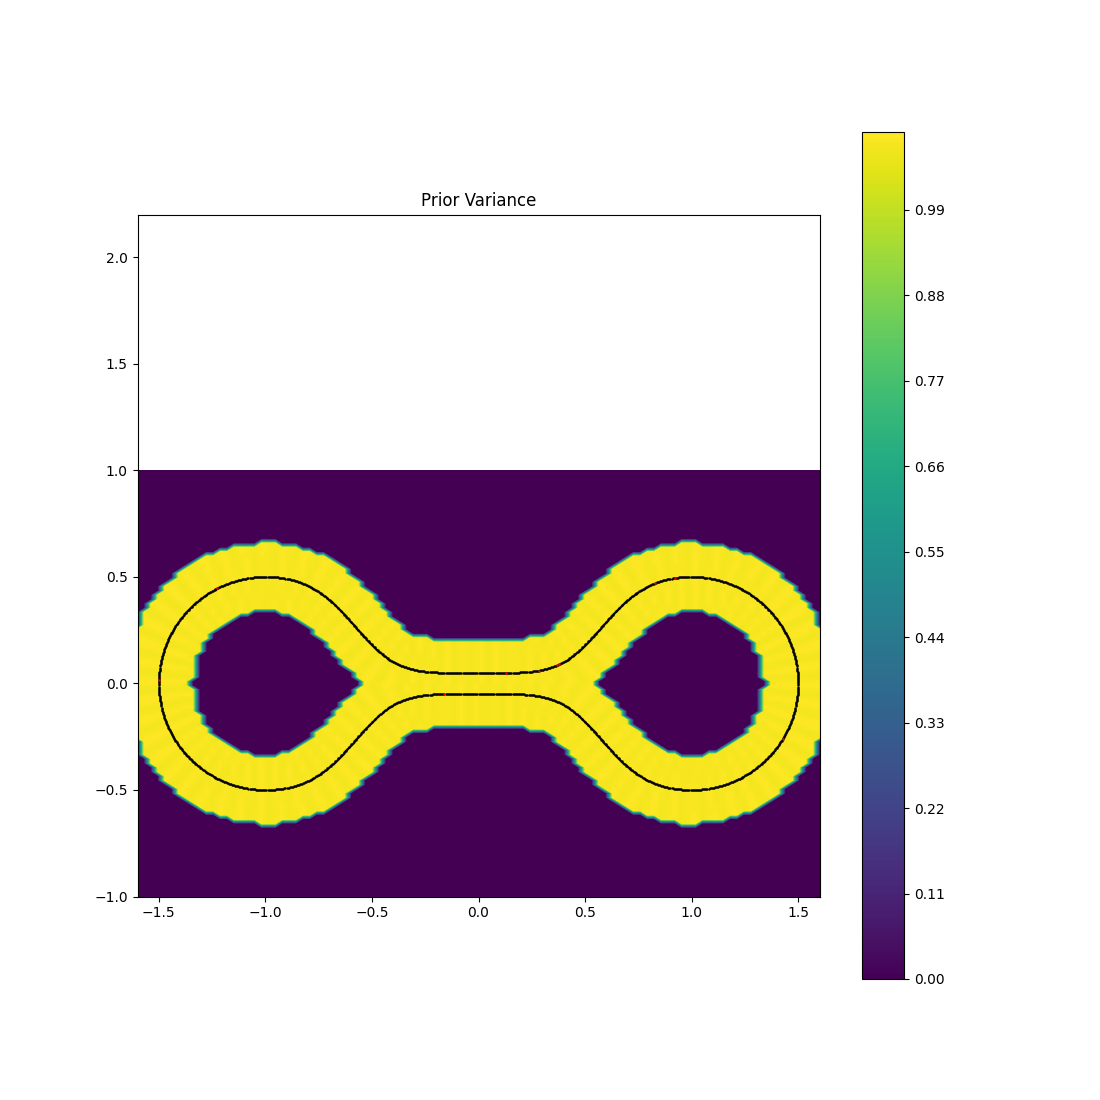

In [23]:
with torch.no_grad():
    prior_std_ambient = model.covar_module(grid_x, grid_x, diag=True).cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), prior_std_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), prior_var_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Prior Variance')

### Ambient Posterior Standard Deviation

/home/bernardo/.local/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:276: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


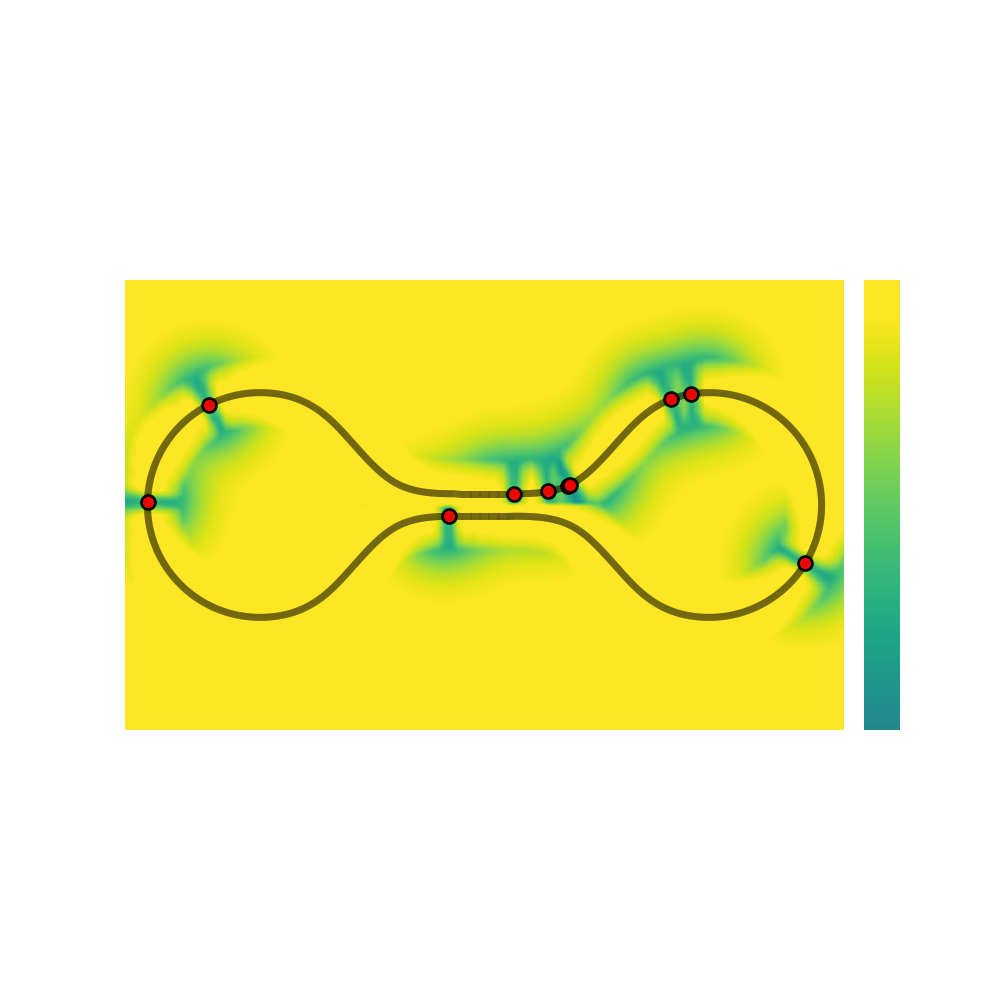

In [24]:
with torch.no_grad():
#     posterior_std_ambient = preds_ambient.stddev.cpu().numpy()
#     posterior_std_ambient = preds_vanilla.stddev.cpu().numpy()
    posterior_std_ambient = (scale_ambient*preds_ambient.stddev + (1-scale_ambient)*preds_vanilla.stddev).cpu().numpy()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    im = ax.contourf(x.cpu(), y.cpu(), posterior_std_ambient.reshape(resolution, -1), 500, vmin=0, vmax=1)
    # ax.contour(x.cpu(), y.cpu(), posterior_std_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
#     ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], facecolors='red',s=100.0, zorder=2, 
               edgecolors='black', linewidth=2, alpha=0.9)
    for edge in edges:
        start = vertices[edge[0]]
        end = vertices[edge[1]]
        ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax, ticks=[-1.85, 0, 1.1])
    cax.yaxis.set_ticks_position("left")
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    fig.patch.set_visible(False)
    ax.axis('off')
    
    for c in im.collections:
        c.set_edgecolor("face")
    
    ax.axis('equal')
    fig.savefig("1d_riemann_uncertainty.png", format="png", bbox_inches="tight")
#     ax.set_title('Standard Deviation')

### Ambient Alpha Function

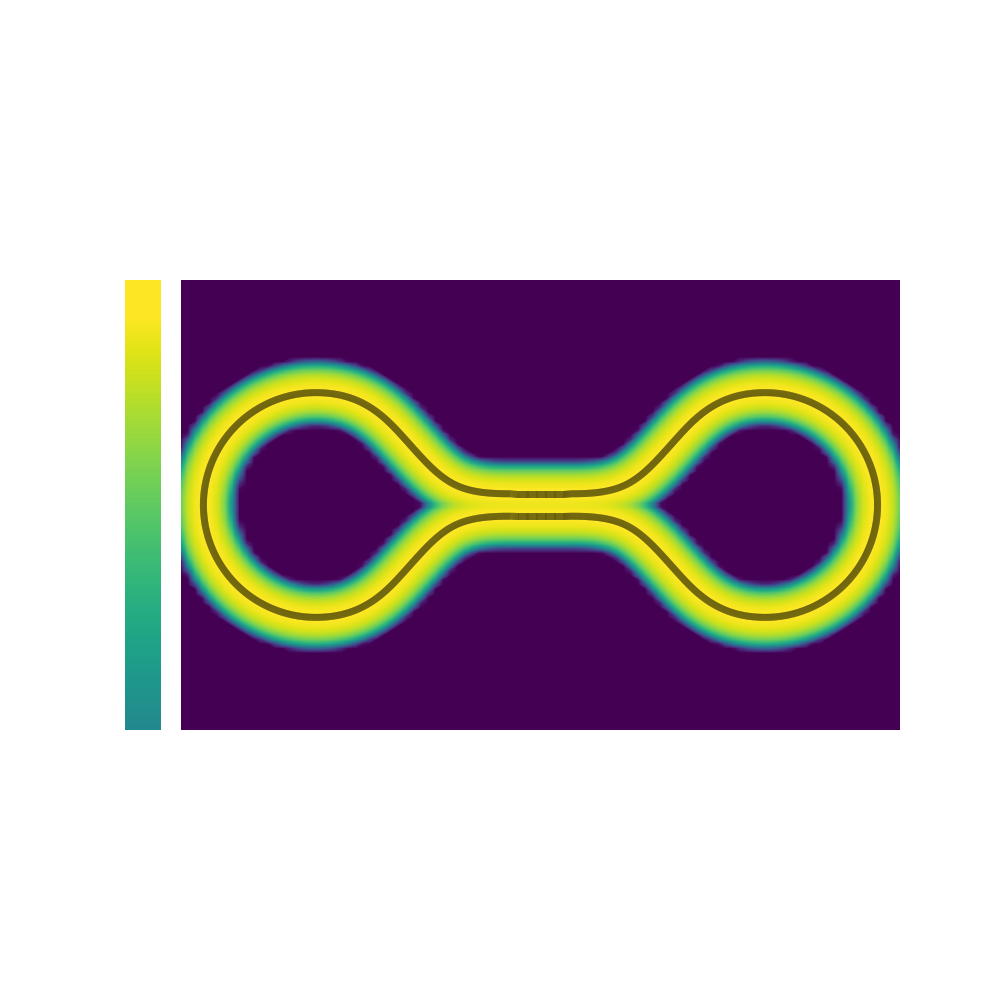

In [25]:
with torch.no_grad():
    c = kernel.base_kernel.ball_scale
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), scale_ambient.cpu().numpy().reshape(resolution, -1), 500)
#     ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
#     ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
#     circle = plt.Circle((noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1]), 
#                         c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
#     ax.add_patch(circle)
    for edge in edges:
        start = vertices[edge[0]]
        end = vertices[edge[1]]
        ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="5%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax, ticks=[-1.85, 0, 1.1])
    cax.yaxis.set_ticks_position("left")
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('equal')
    
    for c in im.collections:
        c.set_edgecolor("face")
    
    ax.axis('equal')
    fig.savefig("1d_alpha_fun.png", format="png", bbox_inches="tight")